# Olist Analysis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import squarify

In [2]:
conn = sqlite3.connect("data/olist.sqlite")
c = conn.cursor()

## Revenue by category

In [3]:
# write the query
query = """
WITH perc_table
AS
(
	SELECT 
	DISTINCT order_year,
		product_category_name, 
		SUM(sid.price) OVER (PARTITION BY [order_year],[product_category_name]) / 
		SUM(sid.price) OVER (PARTITION BY order_year)*100 AS rev_perc
	FROM sales_item_detail sid
	WHERE (order_year AND product_category_name IS NOT NULL) 
)
SELECT 
order_year,
count(*),
CASE
	WHEN rev_perc < 2 THEN "less then 2%"
	WHEN rev_perc >=2 AND rev_perc < 5 THEN "between 2% and 5%"
	WHEN rev_perc >=5 AND rev_perc < 8 THEN "between 5% and 8%"
	ELSE "greater than 8%" 
END new_group
FROM perc_table
GROUP BY order_year, new_group
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
sales = pd.read_sql_query(query, conn)

In [59]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=sales, kind="bar",
    x="order_year", y="count(*)", hue="new_group",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Number of categories")
g.legend.set_title("")

In [5]:
# write the query
query = """
WITH perc_table
AS
(
	SELECT 
	DISTINCT order_year,
		product_category_name, 
		SUM(sid.price) OVER (PARTITION BY [order_year],[product_category_name]) / 
		SUM(sid.price) OVER (PARTITION BY order_year)*100 AS rev_perc
	FROM sales_item_detail sid
	WHERE (order_year AND product_category_name IS NOT NULL) 
)
SELECT * FROM perc_table
WHERE rev_perc > 2
ORDER BY rev_perc DESC 
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
sales_2 = pd.read_sql_query(query, conn)

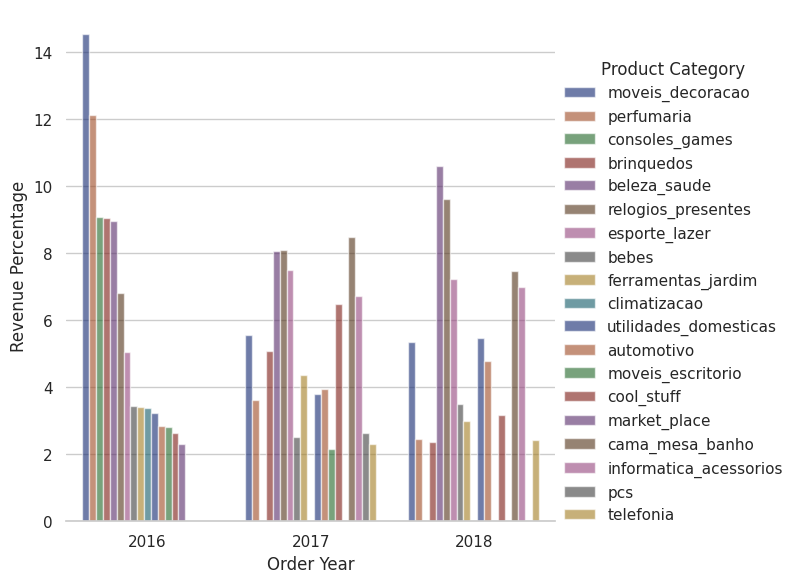

In [6]:
# Sort the data within each order_year by rev_perc
sales_2_sorted = sales_2.sort_values(by=["order_year", "rev_perc"], ascending=[True, False])

# Draw the barplot with sorted data within each group
g = sns.catplot(
    data=sales_2_sorted, kind="bar",
    x="order_year", y="rev_perc", hue="product_category_name",
    palette="dark", alpha=.6, height=6
)

# Adjust the appearance
g.despine(left=True)
g.set_axis_labels("Order Year", "Revenue Percentage")
g.legend.set_title("Product Category")

plt.show()

## Seller vs customer location

In [43]:
query = """
WITH sel_vs_cos_st AS (
    SELECT 
        seller_state || ' - ' || customer_state AS seller_customer,
        sid.product_category_name,
        sid.order_year,
        COUNT(DISTINCT order_id) AS ord_count
    FROM 
        sales_item_detail sid
    WHERE sid.order_year AND sid.product_category_name IS NOT NULL
   	GROUP BY  
        sid.order_year, sid.product_category_name
),
total_orders AS (
    SELECT 
    SUM(ord_count) AS total_ord_count
    FROM sel_vs_cos_st
)
SELECT
	order_year,    
	seller_customer,
    product_category_name,
    ord_count
FROM 
    sel_vs_cos_st
ORDER BY 
    seller_customer DESC
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
delivery_states_perc = pd.read_sql_query(query, conn)

In [56]:
delivery_states_perc2 = delivery_states_perc[delivery_states_perc['order_year'] != '2016']
total_year = delivery_states_perc2['ord_count'].sum()
delivery_states_perc2['perc_year'] = delivery_states_perc2['ord_count']/total_year*100

/tmp/ipykernel_73178/299579588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_states_perc2['perc_year'] = delivery_states_perc2['ord_count']/total_year*100


In [57]:
delivery_states_perc2

,order_year,seller_customer,product_category_name,ord_count,perc_year
6,2017,SP - SP,audio,157,0.165324
7,2017,SP - SP,bebes,1161,1.222556
8,2017,SP - SP,bebidas,70,0.073711
9,2017,SP - SP,beleza_saude,3281,3.454957
10,2017,SP - SP,cama_mesa_banho,4367,4.598536
...,...,...,...,...,...
168,2017,GO - SP,dvds_blu_ray,34,0.035803
169,2017,GO - ES,cool_stuff,2140,2.253462
170,2017,ES - RJ,ferramentas_jardim,1914,2.015479
171,2017,BA - MG,pcs,119,0.125309


/tmp/ipykernel_73178/3088494376.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


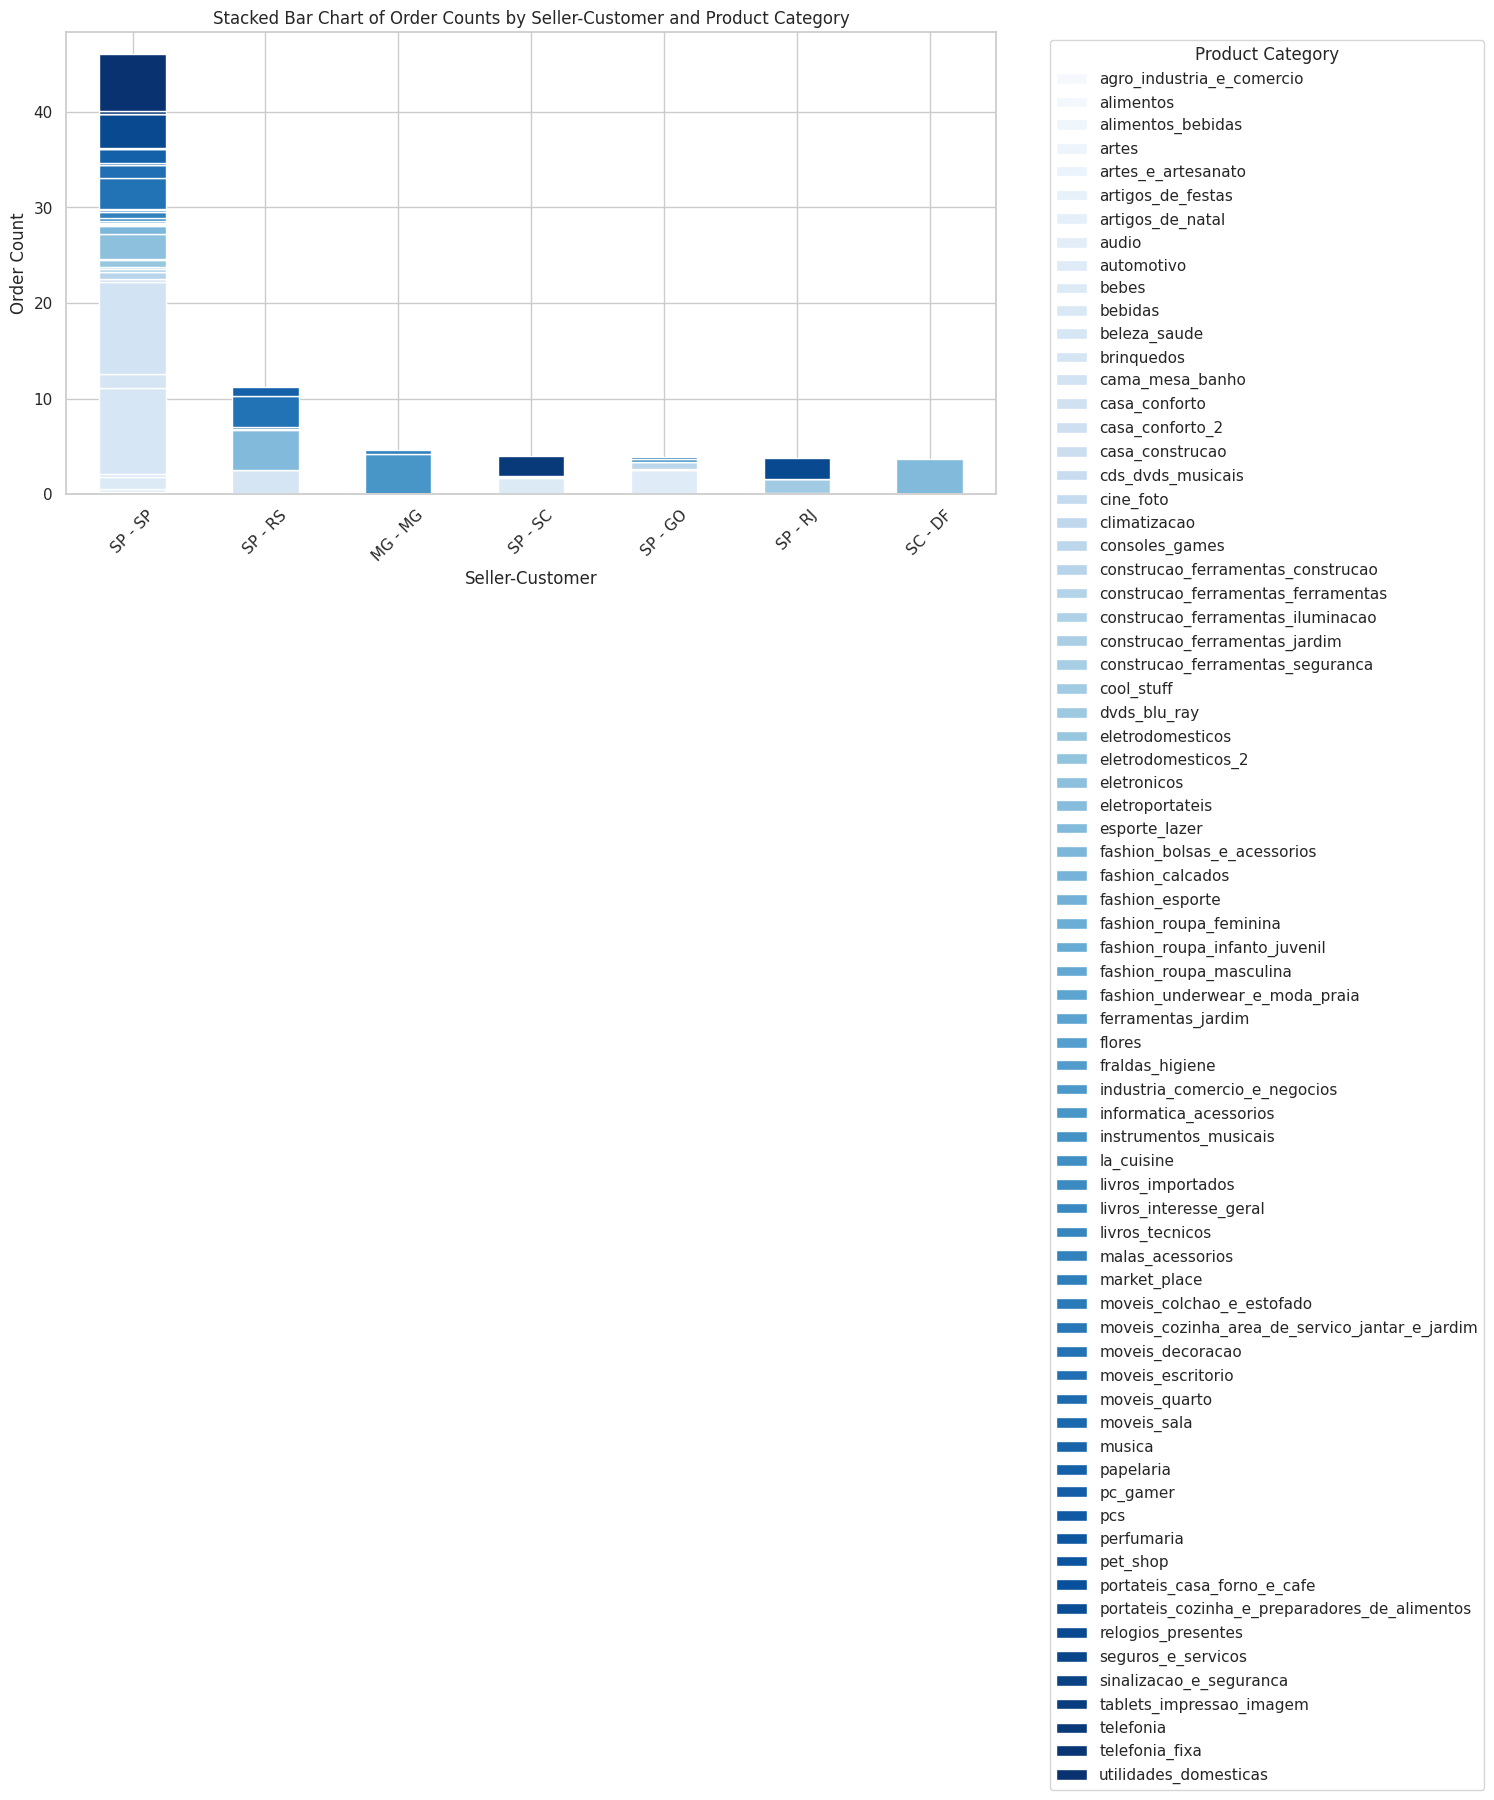

In [58]:
df = delivery_states_perc2

# Aggregate the order counts per seller_customer and product_category
aggregated_df = df.groupby(['seller_customer', 'product_category_name'])['perc_year'].sum().reset_index()

# Pivot the DataFrame for the stacked bar chart
pivot_df = aggregated_df.pivot(index='seller_customer', columns='product_category_name', values='perc_year').fillna(0)

# Calculate total order counts for sorting
pivot_df['total'] = pivot_df.sum(axis=1)

# Filter out rows where total < 3%
pivot_df = pivot_df[pivot_df['total'] >= 3]

# Sort the pivot table by total order counts
pivot_df = pivot_df.sort_values(by='total', ascending=False)

# Drop the 'total' column for the plotting
pivot_df = pivot_df.drop(columns='total')

# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create the stacked bar chart with a blue color palette
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=sns.color_palette("Blues", n_colors=len(pivot_df.columns)))

# Adding titles and labels
plt.title("Stacked Bar Chart of Order Counts by Seller-Customer and Product Category")
plt.xlabel("Seller-Customer")
plt.ylabel("Order Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [13]:
query = """
SELECT
	gld.order_id,
	gld.freight_value,
	gld.seller_state,
	gld.customer_state,
	distance_km,
	ov.order_volume,
	sid.order_year 
	FROM geo_loc_det gld
INNER JOIN order_vol ov ON ov.order_id = gld.order_id
INNER JOIN sales_item_detail sid ON sid.order_id = gld.order_id 
GROUP BY gld.order_id 
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
delivery_dist = pd.read_sql_query(query, conn)

In [14]:
delivery_dist

,order_id,freight_value,seller_state,customer_state,distance_km,order_volume,order_year
0,00010242fe8c5a6d1ba2dd792cb16214,13.29,SP,RJ,305.349850,3528.0,2017
1,00018f77f2f0320c557190d7a144bdd3,19.93,SP,SP,69.765924,60000.0,2017
2,000229ec398224ef6ca0657da4fc703e,17.87,MG,MG,308.215258,14157.0,2018
3,00024acbcdf0a6daa1e931b038114c75,12.79,SP,SP,299.216968,2400.0,2018
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14,PR,SP,646.721943,42000.0,2017
...,...,...,...,...,...,...,...
95352,fffc94f6ce00a00581880bf54a75a037,43.41,SC,MA,2747.408857,53400.0,2018
95353,fffcd46ef2263f404302a634eb57f7eb,36.53,SP,PR,355.084778,44460.0,2018
95354,fffce4705a9662cd70adb13d4a31832d,16.95,PR,SP,339.459037,9576.0,2017
95355,fffe18544ffabc95dfada21779c9644f,8.72,SP,SP,71.199380,8000.0,2017


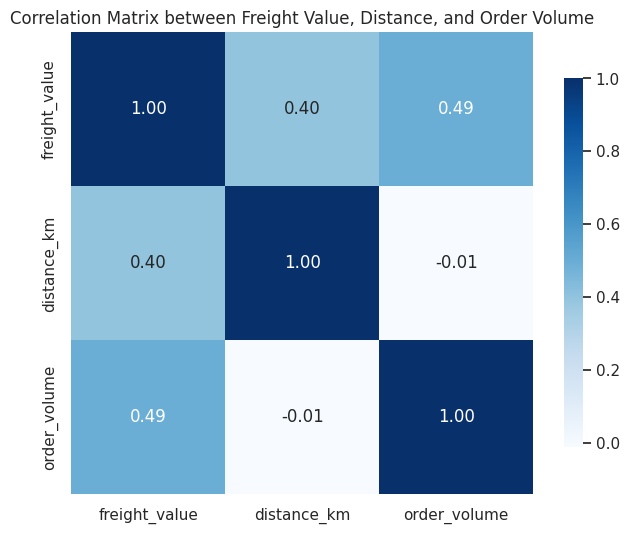

In [15]:
# Select only the relevant columns
# delivery_dist2 = delivery_dist[(delivery_dist['order_year'] != '2016') & (delivery_dist['customer_state'] == 'SP' )]
correlation_data = delivery_dist[["freight_value", "distance_km", "order_volume"]]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix between Freight Value, Distance, and Order Volume")
# Save the heatmap as a PNG file
# plt.savefig("correlation_matrix_heatmap.png", bbox_inches='tight')  # You can specify the file format here
plt.show()

## Customer satisfaction

In [16]:
query = """
WITH rev_avg_table
AS(
SELECT 
	DISTINCT order_year, 
	product_category_name,
	ROUND(AVG(customer_review) OVER (PARTITION BY product_category_name),2) AS avg_rev
FROM sales_item_detail sid 
WHERE (order_year AND product_category_name IS NOT NULL)
)
SELECT * FROM rev_avg_table
ORDER BY order_year, avg_rev DESC;
"""
# Execute the query
c.execute(query)
#Fetch and print the results
c.fetchall()
cust_rev = pd.read_sql_query(query, conn)

In [17]:
cust_rev

,order_year,product_category_name,avg_rev
0,2016,fashion_calcados,4.29
1,2016,alimentos,4.26
2,2016,perfumaria,4.22
3,2016,pet_shop,4.22
4,2016,brinquedos,4.21
...,...,...,...
168,2018,casa_conforto_2,3.63
169,2018,pc_gamer,3.63
170,2018,moveis_escritorio,3.52
171,2018,portateis_cozinha_e_preparadores_de_alimentos,3.43


In [18]:
df2=cust_rev[cust_rev['order_year'] == "2016"]

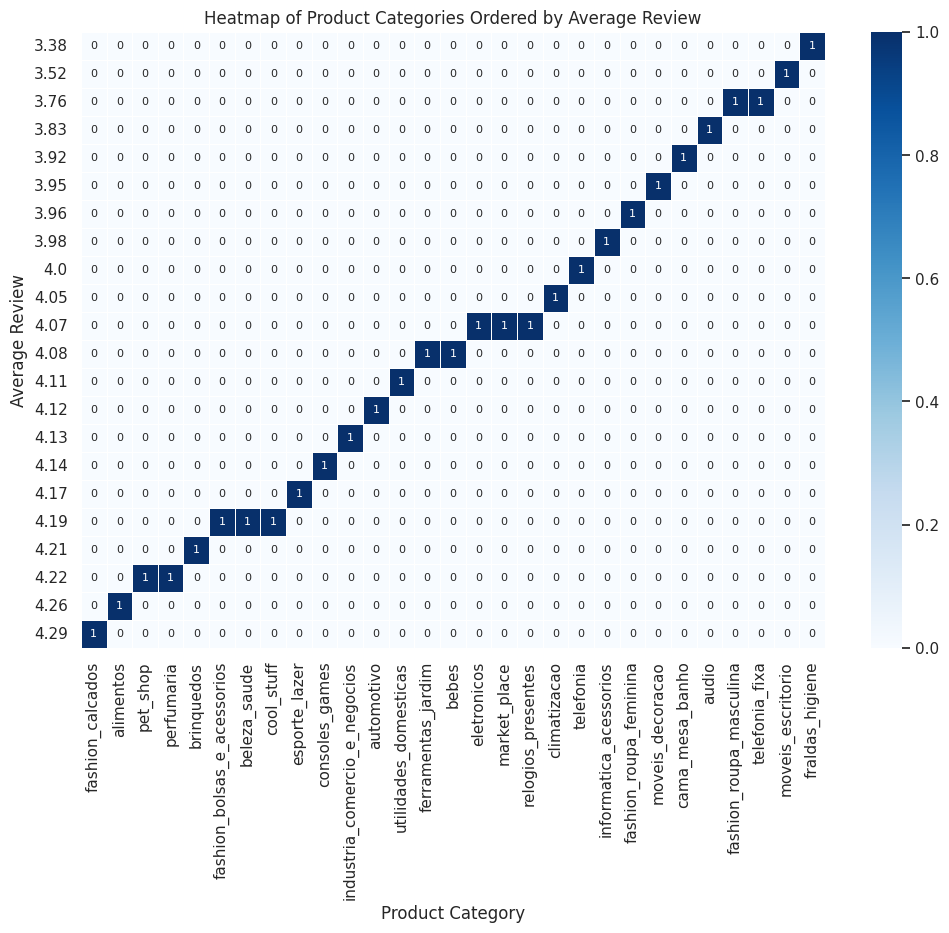

In [19]:
# Step 1: Calculate the average review score for each product category
avg_reviews = df2.groupby('product_category_name')['avg_rev'].mean().sort_values(ascending=False)

# Step 2: Create a pivot table for the count of occurrences of each product category
# Use the sorted product categories as columns
state_counts = df2.pivot_table(index='avg_rev', columns='product_category_name', 
                                aggfunc='size', fill_value=0)

# Step 3: Reorder the columns of the pivot table based on average reviews
state_counts = state_counts[avg_reviews.index]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 4: Plot the heatmap with a smaller font size for annotations
sns.heatmap(state_counts, annot=True, cmap='Blues', fmt='d', linewidths=.5, annot_kws={"size": 8})

# Set titles and labels
plt.title('Heatmap of Product Categories Ordered by Average Review')
plt.xlabel('Product Category')
plt.ylabel('Average Review')

# Save the plot as an image (e.g., PNG)
# plt.savefig("product_category_avg_review_heatmap.png", dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

In [20]:
df3=cust_rev[cust_rev['order_year'] == "2017"]

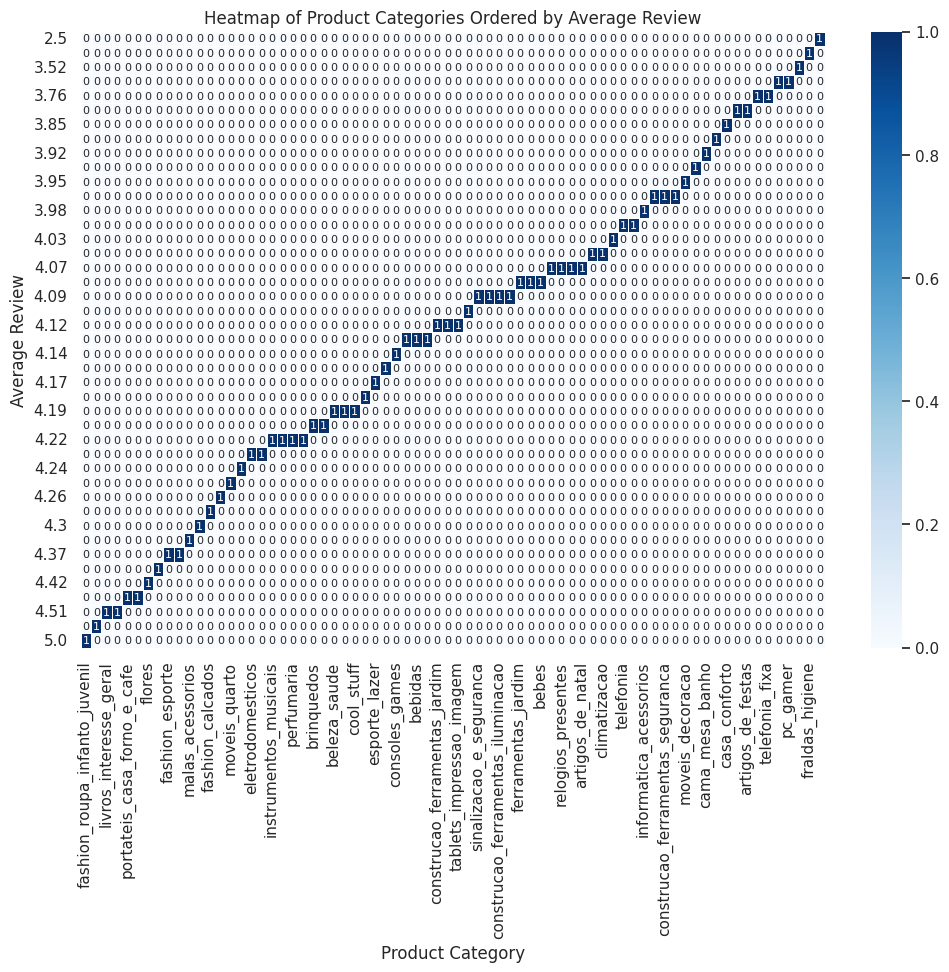

In [21]:
# Step 1: Calculate the average review score for each product category
avg_reviews = df3.groupby('product_category_name')['avg_rev'].mean().sort_values(ascending=False)

# Step 2: Create a pivot table for the count of occurrences of each product category
# Use the sorted product categories as columns
state_counts = df3.pivot_table(index='avg_rev', columns='product_category_name', 
                                aggfunc='size', fill_value=0)

# Step 3: Reorder the columns of the pivot table based on average reviews
state_counts = state_counts[avg_reviews.index]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 4: Plot the heatmap with a smaller font size for annotations
sns.heatmap(state_counts, annot=True, cmap='Blues', fmt='d', linewidths=.5, annot_kws={"size": 8})

# Set titles and labels
plt.title('Heatmap of Product Categories Ordered by Average Review')
plt.xlabel('Product Category')
plt.ylabel('Average Review')

# Save the plot as an image (e.g., PNG)
# plt.savefig("product_category_avg_review_heatmap.png", dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

In [22]:
df4=cust_rev[cust_rev['order_year'] == "2018"]

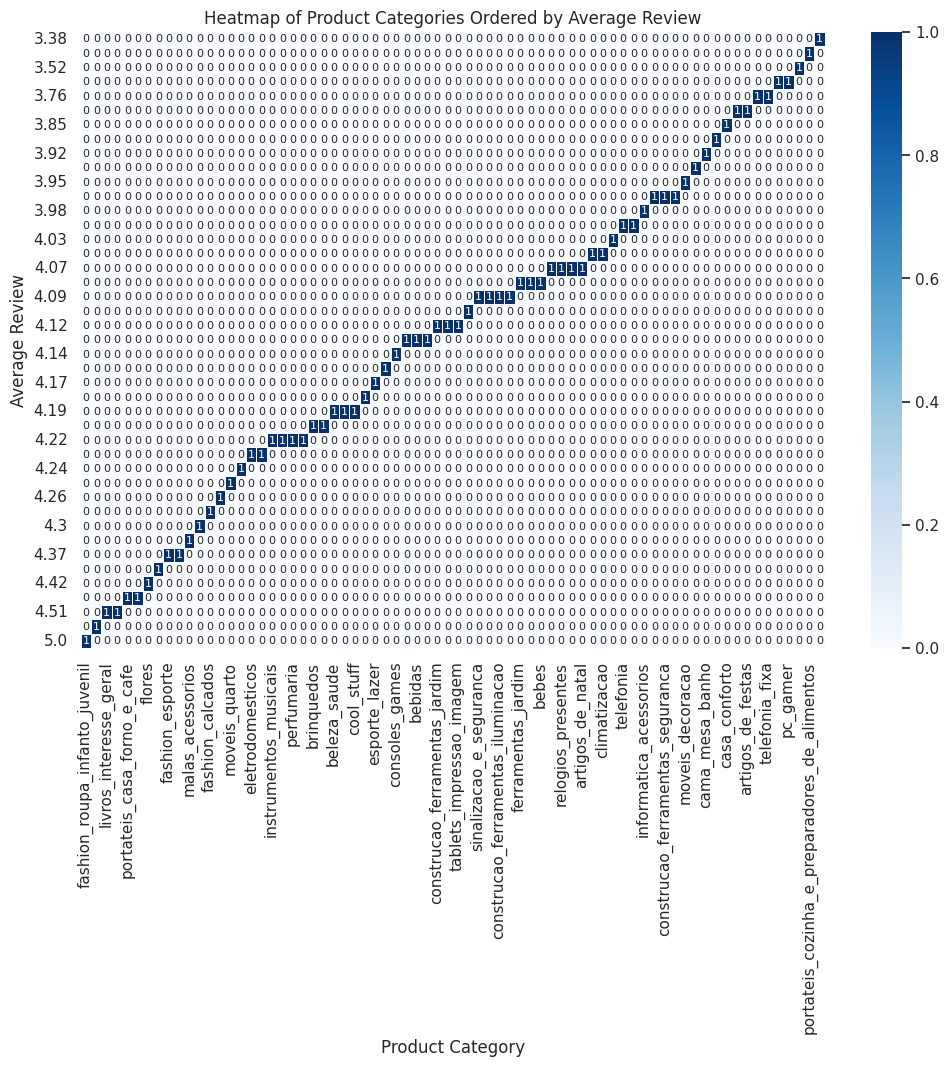

In [23]:
# Step 1: Calculate the average review score for each product category
avg_reviews = df4.groupby('product_category_name')['avg_rev'].mean().sort_values(ascending=False)

# Step 2: Create a pivot table for the count of occurrences of each product category
# Use the sorted product categories as columns
state_counts = df4.pivot_table(index='avg_rev', columns='product_category_name', 
                                aggfunc='size', fill_value=0)

# Step 3: Reorder the columns of the pivot table based on average reviews
state_counts = state_counts[avg_reviews.index]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Step 4: Plot the heatmap with a smaller font size for annotations
sns.heatmap(state_counts, annot=True, cmap='Blues', fmt='d', linewidths=.5, annot_kws={"size": 8})

# Set titles and labels
plt.title('Heatmap of Product Categories Ordered by Average Review')
plt.xlabel('Product Category')
plt.ylabel('Average Review')

# Save the plot as an image (e.g., PNG)
# plt.savefig("product_category_avg_review_heatmap.png", dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()